In [1]:
# import Python packages, modules and functions

%matplotlib inline

import numpy as np
import pandas as pd
import h2o
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2ORandomForestEstimator
import matplotlib.pyplot as plt
from dataGeneratorClass import dataGenerator, plotData # this module is on my GitHub page
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, brier_score_loss
import warnings
from importlib import reload
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',500)
pd.set_option('display.max_colwidth', -1)
def pretty_df(df, n = 10):
    return (df.head(n).style.
            set_properties(
            **{'text-align': 'center',
               'white-space': 'nowrap'}))

In [2]:
# Generate data 

catg_lvls = [5, 8, 3] # 3 categorical variables with corresponding # of levels
n_cat = len(catg_lvls)
n_beta = 2 # number of beta variables
n_uniform = 1 # of uniform variables
n = n_cat + n_beta + n_uniform
N = 120000 # number of observations
responseMean = 0.05 # Bernoulli response mean
p_width = 0.1
np.random.seed(123)
trainPercent = 2./3 # fraction of data for training
testPercent = 1./6 # fraction of data for test
Ntrain = int(N * trainPercent);
Ntest = int(N * testPercent)

# Generate data
x = dataGenerator(
    catg_lvls = catg_lvls,
    n_beta = n_beta,
    n_uniform = n_uniform
)

df1, df2 = x.generate(1000)

f = x.genSigmoidTransform(
    df2,
    loc = responseMean,
    width = p_width
)

df1, df2 = x.generate_more(N)

df = pd.concat(
    [df1,
     pd.DataFrame(
            x.genBernoulliVariates(df2,f),
            columns=['Response'])
    ],
    axis=1)

In [3]:
# Split data into train, test and validate
train, test, validate = np.split(
    df.sample(frac=1,random_state = 0),
    indices_or_sections=[Ntrain,Ntrain + Ntest]
)

train = train.reset_index()
test = test.reset_index()
validate = validate.reset_index()

In [4]:
# Take a look at the training data
pretty_df(train)

,index,Feature: 0,Feature: 1,Feature: 2,Feature: 3,Feature: 4,Feature: 5,Response
0,40739,3,4,1,0.194392,0.205206,0.682438,0
1,105532,1,5,1,0.0886995,0.579297,0.979833,1
2,45004,2,4,2,0.222101,0.0586179,0.859653,0
3,71894,3,5,0,0.277352,0.474923,0.0230137,0
4,11970,4,7,1,0.108871,0.325363,0.353809,0
5,9382,1,4,1,0.405997,0.327751,0.10401,0
6,30582,2,2,1,0.291029,0.285454,0.520948,0
7,110897,2,4,0,0.164112,0.273223,0.0710168,0
8,64112,1,3,1,0.474486,0.0190688,0.498027,0
9,77897,3,6,0,0.102382,0.793129,0.428013,0


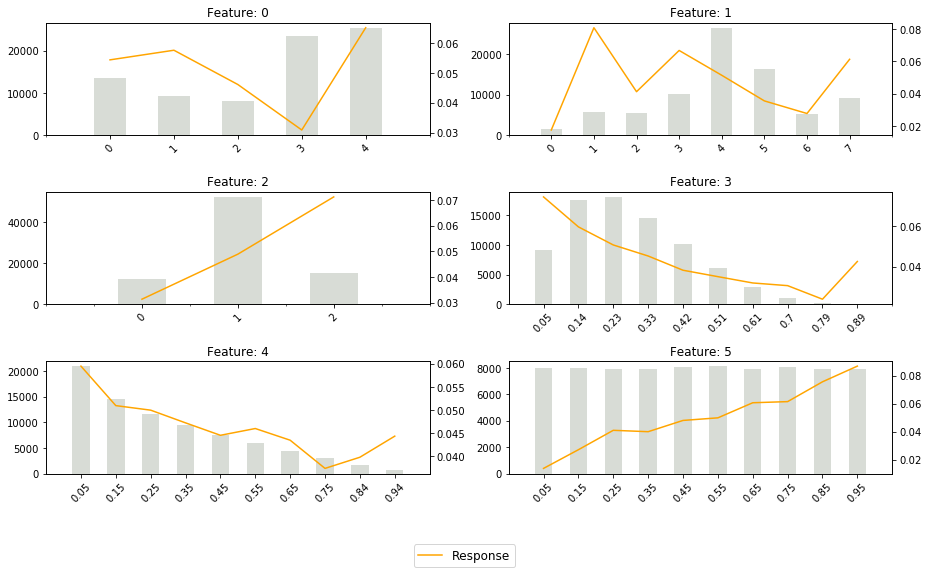

In [5]:
# Plot the training data
plotData(train.loc[:,train.columns != 'index'], response = 'Response')

In [6]:
# Initialize h2o instance
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.221-b11, mixed mode)
  Starting server from C:\Users\Gregory\Anaconda2\envs\python35\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Gregory\AppData\Local\Temp\tmpxrwfb2g2
  JVM stdout: C:\Users\Gregory\AppData\Local\Temp\tmpxrwfb2g2\h2o_Gregory_started_from_python.out
  JVM stderr: C:\Users\Gregory\AppData\Local\Temp\tmpxrwfb2g2\h2o_Gregory_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,"1 year, 3 months and 14 days !!!"
H2O cluster name:,H2O_from_python_Gregory_f7dk5q
H2O cluster total nodes:,1
H2O cluster free memory:,1.761 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [7]:
# Construct dictionary of categorical variables
cat_dict = {
    k: 'categorical' for k, v
    in train.dtypes.to_dict().items()
    if v.name == 'category'
}

cat_dict['Response'] = 'categorical'

In [8]:
# Read pandas dataframes into h2o
train_h2o = h2o.H2OFrame(
    train,
    column_types=cat_dict
)

test_h2o = h2o.H2OFrame(
    test,
    column_types=cat_dict
)

validate_h2o = h2o.H2OFrame(
    validate,
    column_types=cat_dict
)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [9]:
# Print h2o training data
train_h2o

index,Feature: 0,Feature: 1,Feature: 2,Feature: 3,Feature: 4,Feature: 5,Response
40739,3,4,1,0.194392,0.205206,0.682438,0
105532,1,5,1,0.0886995,0.579297,0.979833,1
45004,2,4,2,0.222101,0.0586179,0.859653,0
71894,3,5,0,0.277352,0.474923,0.0230137,0
11970,4,7,1,0.108871,0.325363,0.353809,0
9382,1,4,1,0.405997,0.327751,0.10401,0
30582,2,2,1,0.291029,0.285454,0.520948,0
110897,2,4,0,0.164112,0.273223,0.0710168,0
64112,1,3,1,0.474486,0.0190688,0.498027,0
77897,3,6,0,0.102382,0.793129,0.428013,0


In [10]:
# Check that categorical variables are indeed factors in h2o
print(
    *[i + ' is a factor: ' + str(j)
    for i,j in zip(train_h2o.col_names,
                   train_h2o.isfactor())
    ],
    sep="\n"
)

index is a factor: False
Feature: 0 is a factor: True
Feature: 1 is a factor: True
Feature: 2 is a factor: True
Feature: 3 is a factor: False
Feature: 4 is a factor: False
Feature: 5 is a factor: False
Response is a factor: True


In [11]:
# Set up gbm parameter grid and fit in h2o
hyper_parameters = {
    'ntrees': [50,100,150,200],
    'max_depth': [2,4,8],
    'learn_rate': [0.01, 0.05, 0.1, 0.2]
}

gbm_grid = H2OGridSearch(
    H2OGradientBoostingEstimator(
        distribution='bernoulli'),
    hyper_parameters
)

gbm_grid.train(
    training_frame = train_h2o,
    x = [i for i in train_h2o.col_names
         if i not in ['Response','index']],
    y = 'Response',
    validation_frame = test_h2o)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [12]:
# Get best gbm and print summary
gbm_grid_perf = gbm_grid.get_grid(
    sort_by='logloss',
    decreasing=False)
best_gbm = gbm_grid_perf.models[0]
print(best_gbm)
print('Gini for the best GBM:')
print(round(best_gbm.model_performance(test_h2o).gini(),3))

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  Grid_GBM_Key_Frame__upload_a2234d320d2ca1275fbd877096048c0.hex_model_python_1567945715396_1_model_27


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.04689835176684326
RMSE: 0.21656027282685822
LogLoss: 0.18902292700837434
Mean Per-Class Error: 0.36610109772231736
AUC: 0.6846472014642496
Gini: 0.36929440292849924
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07315069669112084: 


,0,1,Error,Rate
0,59142.0,16823.0,0.2215,(16823.0/75965.0)
1,2258.0,1777.0,0.5596,(2258.0/4035.0)
Total,61400.0,18600.0,0.2385,(19081.0/80000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0731507,0.1570135,153.0
max f2,0.0533543,0.2732767,220.0
max f0point5,0.1044167,0.1254720,68.0
max accuracy,0.1819214,0.9496375,7.0
max precision,0.3361636,1.0,0.0
max recall,0.0049016,1.0,394.0
max specificity,0.3361636,1.0,0.0
max absolute_mcc,0.0533543,0.1184876,220.0
max min_per_class_accuracy,0.0569842,0.6294919,207.0
max mean_per_class_accuracy,0.0512302,0.6338989,228.0


Gains/Lift Table: Avg response rate:  5.04 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.1182738,3.0235440,3.0235440,0.1525,0.1525,0.0302354,0.0302354,202.3543990,202.3543990
,2,0.02,0.1117674,2.4287485,2.7261462,0.1225,0.1375,0.0242875,0.0545229,142.8748451,172.6146221
,3,0.0301125,0.1081197,2.4262364,2.6254293,0.1223733,0.1324201,0.0245353,0.0790582,142.6236439,162.5429320
,4,0.04,0.1044959,2.5065130,2.5960347,0.1264223,0.1309375,0.0247831,0.1038414,150.6513017,159.6034696
,5,0.0500125,0.1020652,1.7574067,2.4281414,0.0886392,0.1224694,0.0175960,0.1214374,75.7406711,142.8141416
,6,0.1001875,0.0925938,1.9164646,2.1718881,0.0966617,0.1095446,0.0961586,0.2175960,91.6464617,117.1888057
,7,0.15,0.0841210,1.8010538,2.0487402,0.0908407,0.1033333,0.0897150,0.3073110,80.1053828,104.8740190
,8,0.2000625,0.0772541,1.5940421,1.9349591,0.0803995,0.0975945,0.0798017,0.3871128,59.4042144,93.4959142
,9,0.3,0.0648821,1.4482410,1.7728211,0.0730457,0.0894167,0.1447336,0.5318463,44.8240962,77.2821148
,10,0.4,0.0550458,1.1747212,1.6232962,0.05925,0.081875,0.1174721,0.6493185,17.4721190,62.3296159




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.04608533153085346
RMSE: 0.2146749438822646
LogLoss: 0.1875194083880317
Mean Per-Class Error: 0.3691442123192793
AUC: 0.6669806406073105
Gini: 0.3339612812146211
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07500535510845036: 


,0,1,Error,Rate
0,15032.0,3984.0,0.2095,(3984.0/19016.0)
1,610.0,374.0,0.6199,(610.0/984.0)
Total,15642.0,4358.0,0.2297,(4594.0/20000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0750054,0.1400225,140.0
max f2,0.0505459,0.2652070,224.0
max f0point5,0.0893495,0.1025446,99.0
max accuracy,0.1891060,0.9508,1.0
max precision,0.1891060,0.5,1.0
max recall,0.0090998,1.0,381.0
max specificity,0.2070402,0.9999474,0.0
max absolute_mcc,0.0430981,0.1135328,252.0
max min_per_class_accuracy,0.0556822,0.6189024,204.0
max mean_per_class_accuracy,0.0430981,0.6308558,252.0


Gains/Lift Table: Avg response rate:  4.92 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01015,0.1190487,2.4029797,2.4029797,0.1182266,0.1182266,0.0243902,0.0243902,140.2979695,140.2979695
,2,0.02,0.1119841,1.3412571,1.8800813,0.0659898,0.0925,0.0132114,0.0376016,34.1257067,88.0081301
,3,0.03,0.1079808,1.8292683,1.8631436,0.09,0.0916667,0.0182927,0.0558943,82.9268293,86.3143631
,4,0.04005,0.1047077,2.0224083,1.9031089,0.0995025,0.0936330,0.0203252,0.0762195,102.2408284,90.3108919
,5,0.05035,0.1020530,2.0719867,1.9376559,0.1019417,0.0953327,0.0213415,0.0975610,107.1986739,93.7655921
,6,0.1,0.0924362,1.8012265,1.8699187,0.0886203,0.092,0.0894309,0.1869919,80.1226471,86.9918699
,7,0.1501,0.0843589,1.5213475,1.7535735,0.0748503,0.0862758,0.0762195,0.2632114,52.1347549,75.3573498
,8,0.2002,0.0775643,1.5619168,1.7056115,0.0768463,0.0839161,0.0782520,0.3414634,56.1916817,70.5611462
,9,0.3,0.0648107,1.4459814,1.6192412,0.0711423,0.0796667,0.1443089,0.4857724,44.5981394,61.9241192
,10,0.4001,0.0545792,1.4721051,1.5824296,0.0724276,0.0778555,0.1473577,0.6331301,47.2105131,58.2429596



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2019-09-08 06:31:22,2 min 22.858 sec,0.0,0.2188460,0.1998014,0.5,1.0,0.9495625,0.2162889,0.1961690,0.5,1.0,0.9508
,2019-09-08 06:31:22,2 min 22.932 sec,1.0,0.2184749,0.1981225,0.6178713,1.5842365,0.2934625,0.2159456,0.1946342,0.6126421,1.5759524,0.29275
,2019-09-08 06:31:22,2 min 22.990 sec,2.0,0.2182066,0.1969046,0.6359545,1.6553152,0.2609625,0.2156973,0.1935061,0.6292935,1.6277935,0.2605
,2019-09-08 06:31:23,2 min 23.047 sec,3.0,0.2180090,0.1960489,0.6480502,1.8940652,0.2525875,0.2154919,0.1926143,0.6436581,1.8563001,0.2748
,2019-09-08 06:31:23,2 min 23.108 sec,4.0,0.2178547,0.1953039,0.6494291,2.0119934,0.204425,0.2153631,0.1920075,0.6428241,2.1546751,0.2748
---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2019-09-08 06:31:26,2 min 26.590 sec,46.0,0.2167706,0.1898731,0.6786019,2.6533630,0.262975,0.2147509,0.1879911,0.6643760,2.0123964,0.2742
,2019-09-08 06:31:26,2 min 26.676 sec,47.0,0.2167665,0.1898487,0.6786868,2.7261462,0.2627375,0.2147438,0.1879693,0.6644519,2.1235287,0.2762
,2019-09-08 06:31:26,2 min 26.749 sec,48.0,0.2167575,0.1898253,0.6789107,2.7550496,0.263325,0.2147401,0.1879593,0.6644015,2.2357724,0.2759
,2019-09-08 06:31:26,2 min 26.823 sec,49.0,0.2167500,0.1898011,0.6791443,2.7935119,0.262475,0.2147315,0.1879252,0.6648666,2.2357724,0.2749



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Feature: 5,91.7378922,1.0,0.4221333
Feature: 1,44.8925705,0.4893569,0.2065738
Feature: 3,29.9137249,0.3260782,0.1376484
Feature: 0,19.6679497,0.2143929,0.0905024
Feature: 2,17.3748608,0.1893968,0.0799507
Feature: 4,13.7327394,0.1496954,0.0631914



Gini for the best GBM:
0.334


In [13]:
# Use best gbm to score validation set
gbm_validation_preds = (
    best_gbm.predict(validate_h2o)
    .cbind(validate_h2o)
)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [14]:
# Convert scored validation set to pandas dataframe
gbm_validation_preds_df = (
    gbm_validation_preds
    .as_data_frame(
        use_pandas=True))

In [15]:
# Set up random forest parameter grid and fit in h2o
hyper_parameters = {
    'ntrees': [50,100,150,200],
    'max_depth': [8,16]
}

rf_grid = H2OGridSearch(
    H2ORandomForestEstimator(
        distribution='bernoulli'),
    hyper_parameters
)

rf_grid.train(
    training_frame = train_h2o,
    x = [i for i in train_h2o.col_names
         if i not in ['Response','index']],
    y = 'Response',
    validation_frame = test_h2o)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [16]:
# Take a look at grid results
rf_grid

    max_depth ntrees  \
0           8    150   
1           8    100   
2           8    200   
3           8     50   
4          16    200   
5          16    150   
6          16    100   
7          16     50   

                                                               model_ids  \
0  Grid_DRF_Key_Frame__upload_a2234d320d2ca1275fbd877096048c0.hex_mod...   
1  Grid_DRF_Key_Frame__upload_a2234d320d2ca1275fbd877096048c0.hex_mod...   
2  Grid_DRF_Key_Frame__upload_a2234d320d2ca1275fbd877096048c0.hex_mod...   
3  Grid_DRF_Key_Frame__upload_a2234d320d2ca1275fbd877096048c0.hex_mod...   
4  Grid_DRF_Key_Frame__upload_a2234d320d2ca1275fbd877096048c0.hex_mod...   
5  Grid_DRF_Key_Frame__upload_a2234d320d2ca1275fbd877096048c0.hex_mod...   
6  Grid_DRF_Key_Frame__upload_a2234d320d2ca1275fbd877096048c0.hex_mod...   
7  Grid_DRF_Key_Frame__upload_a2234d320d2ca1275fbd877096048c0.hex_mod...   

               logloss  
0  0.18783650855208667  
1  0.18786154713054679  
2   0.1878683016225608 

In [17]:
# Get best random forest from grid and print summary
rf_grid_perf = rf_grid.get_grid(
    sort_by='logloss',
    decreasing=False
)

best_rf = rf_grid_perf.models[0]
print(best_rf)
print('Gini for the best Random Forest:')
print(round(best_rf.model_performance(test_h2o).gini(),3))

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  Grid_DRF_Key_Frame__upload_a2234d320d2ca1275fbd877096048c0.hex_model_python_1567945715396_4470_model_4


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.04716018141596535
RMSE: 0.2171639505442037
LogLoss: 0.191217088726481
Mean Per-Class Error: 0.3786705969316235
AUC: 0.6641357890719745
Gini: 0.3282715781439489
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06929630160239679: 


,0,1,Error,Rate
0,57422.0,18543.0,0.2441,(18543.0/75965.0)
1,2247.0,1788.0,0.5569,(2247.0/4035.0)
Total,59669.0,20331.0,0.2599,(20790.0/80000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0692963,0.1467619,163.0
max f2,0.0509619,0.2629788,228.0
max f0point5,0.0829511,0.1073782,122.0
max accuracy,0.2937827,0.9495625,1.0
max precision,0.2937827,0.5,1.0
max recall,0.0021195,1.0,399.0
max specificity,0.3335826,0.9999868,0.0
max absolute_mcc,0.0509619,0.1063867,228.0
max min_per_class_accuracy,0.0556487,0.6146910,210.0
max mean_per_class_accuracy,0.0497767,0.6213294,233.0


Gains/Lift Table: Avg response rate:  5.04 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.1124991,1.9330855,1.9330855,0.0975,0.0975,0.0193309,0.0193309,93.3085502,93.3085502
,2,0.02,0.1058936,1.6356877,1.7843866,0.0825,0.09,0.0163569,0.0356877,63.5687732,78.4386617
,3,0.03,0.1024311,2.0074349,1.8587361,0.10125,0.09375,0.0200743,0.0557621,100.7434944,85.8736059
,4,0.04,0.0997904,1.6852540,1.8153656,0.085,0.0915625,0.0168525,0.0726146,68.5254027,81.5365551
,5,0.05,0.0977844,2.1561338,1.8835192,0.10875,0.095,0.0215613,0.0941760,115.6133829,88.3519207
,6,0.1,0.0896386,1.8389095,1.8612144,0.09275,0.093875,0.0919455,0.1861214,83.8909542,86.1214374
,7,0.15,0.0828009,1.8091698,1.8438662,0.09125,0.093,0.0904585,0.2765799,80.9169765,84.3866171
,8,0.2,0.0759710,1.6555143,1.7967782,0.0835,0.090625,0.0827757,0.3593556,65.5514250,79.6778191
,9,0.3,0.0642829,1.3977695,1.6637753,0.0705,0.0839167,0.1397770,0.4991326,39.7769517,66.3775299
,10,0.4,0.0553051,1.2019827,1.5483271,0.060625,0.0780938,0.1201983,0.6193309,20.1982652,54.8327138




ModelMetricsBinomial: drf
** Reported on validation data. **

MSE: 0.04612318479878652
RMSE: 0.2147630899358326
LogLoss: 0.18783650855208667
Mean Per-Class Error: 0.36929769881417784
AUC: 0.6630365667679079
Gini: 0.3260731335358158
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.06499171814984747: 


,0,1,Error,Rate
0,13635.0,5381.0,0.283,(5381.0/19016.0)
1,514.0,470.0,0.5224,(514.0/984.0)
Total,14149.0,5851.0,0.2948,(5895.0/20000.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.0649917,0.1375274,167.0
max f2,0.0503493,0.2650057,223.0
max f0point5,0.0750719,0.0988031,135.0
max accuracy,0.1950748,0.9507,0.0
max precision,0.1458300,0.1764706,12.0
max recall,0.0059025,1.0,390.0
max specificity,0.1950748,0.9998948,0.0
max absolute_mcc,0.0496951,0.1132059,226.0
max min_per_class_accuracy,0.0555214,0.6138211,203.0
max mean_per_class_accuracy,0.0496951,0.6307023,226.0


Gains/Lift Table: Avg response rate:  4.92 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.1111335,1.7276423,1.7276423,0.085,0.085,0.0172764,0.0172764,72.7642276,72.7642276
,2,0.02,0.1050170,1.5243902,1.6260163,0.075,0.08,0.0152439,0.0325203,52.4390244,62.6016260
,3,0.03,0.1018165,1.9308943,1.7276423,0.095,0.085,0.0193089,0.0518293,93.0894309,72.7642276
,4,0.04,0.0995820,2.6422764,1.9563008,0.13,0.09625,0.0264228,0.0782520,164.2276423,95.6300813
,5,0.05,0.0975840,1.7276423,1.9105691,0.085,0.094,0.0172764,0.0955285,72.7642276,91.0569106
,6,0.1,0.0896514,1.4430894,1.6768293,0.071,0.0825,0.0721545,0.1676829,44.3089431,67.6829268
,7,0.15,0.0829381,1.7886179,1.7140921,0.088,0.0843333,0.0894309,0.2571138,78.8617886,71.4092141
,8,0.2,0.0762068,1.6666667,1.7022358,0.082,0.08375,0.0833333,0.3404472,66.6666667,70.2235772
,9,0.3,0.0640223,1.4532520,1.6192412,0.0715,0.0796667,0.1453252,0.4857724,45.3252033,61.9241192
,10,0.4,0.0550333,1.3414634,1.5497967,0.066,0.07625,0.1341463,0.6199187,34.1463415,54.9796748



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2019-09-08 06:34:56,31.766 sec,0.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
,2019-09-08 06:34:56,31.817 sec,1.0,0.2210570,0.2353056,0.6403120,1.6242655,0.3093932,0.2168005,0.2350607,0.6380908,1.5022976,0.2017
,2019-09-08 06:34:56,31.885 sec,2.0,0.2182330,0.2262923,0.6457146,1.4659607,0.3038575,0.2160367,0.1956180,0.6462567,1.3664002,0.2139
,2019-09-08 06:34:56,31.987 sec,3.0,0.2187400,0.2208661,0.6481041,1.5288502,0.2909988,0.2156775,0.1903931,0.6459807,1.0596078,0.2144
,2019-09-08 06:34:56,32.089 sec,4.0,0.2181538,0.2186628,0.6459427,1.5684761,0.2897086,0.2154562,0.1899501,0.6468481,1.4227642,0.2656
---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2019-09-08 06:34:59,34.921 sec,21.0,0.2174086,0.1927077,0.6596503,1.6356877,0.2568568,0.2147917,0.1879236,0.6631811,1.8292683,0.2024
,2019-09-08 06:34:59,35.141 sec,22.0,0.2173823,0.1926560,0.6600522,1.7843866,0.2691385,0.2147876,0.1879030,0.6631498,1.7276423,0.1991
,2019-09-08 06:35:00,35.381 sec,23.0,0.2173701,0.1926119,0.6604918,1.5861214,0.2488624,0.2147848,0.1878838,0.6632161,1.6260163,0.2871
,2019-09-08 06:35:00,35.633 sec,24.0,0.2173797,0.1922451,0.6604028,1.6852540,0.2345154,0.2147778,0.1878698,0.6632049,1.9308943,0.29575



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
Feature: 5,4429.5429688,1.0,0.3312378
Feature: 3,2712.8071289,0.6124350,0.2028616
Feature: 4,2004.4407959,0.4525164,0.1498905
Feature: 1,1706.8134766,0.3853250,0.1276342
Feature: 0,1629.4631348,0.3678626,0.1218500
Feature: 2,889.6311646,0.2008404,0.0665259



Gini for the best Random Forest:
0.326


In [18]:
# Use best random forest to score validation set
rf_validation_preds = (
    best_rf.predict(validate_h2o)
    .cbind(validate_h2o))

drf prediction progress: |████████████████████████████████████████████████| 100%


In [19]:
# Convert scored validation set to pandas dataframe
rf_validation_preds_df = (
    rf_validation_preds
    .as_data_frame(use_pandas=True))

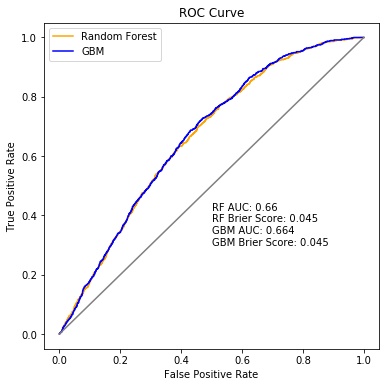

In [20]:
# Construct ROC curves, calculate AUC and Brier Score and plot
fpr_rf, tpr_rf, thresholds_rf = roc_curve(
    rf_validation_preds_df.Response,
    rf_validation_preds_df.p1)

AUC_rf = roc_auc_score(
    rf_validation_preds_df.Response,
    rf_validation_preds_df.p1)

BrierScore_rf = brier_score_loss(
    rf_validation_preds_df.Response,
    rf_validation_preds_df.p1)

fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(
    gbm_validation_preds_df.Response,
    gbm_validation_preds_df.p1)

AUC_gbm = roc_auc_score(
    gbm_validation_preds_df.Response,
    gbm_validation_preds_df.p1)

BrierScore_gbm = brier_score_loss(
    gbm_validation_preds_df.Response,
    gbm_validation_preds_df.p1)

fig, axes = plt.subplots(1,1,figsize=(6,6))

axes.plot(
    fpr_rf,
    tpr_rf,
    color = 'orange',
    label = 'Random Forest')

axes.plot(
    fpr_gbm,
    tpr_gbm,
    color = 'blue',
    label = 'GBM')

axes.plot(
    np.array([0,1]),
    np.array([0,1]),
    color = 'grey')

axes.text(
    .5,
    .3,
    ('RF AUC: {0}' + 
     '\nRF Brier Score: {1}' +
     '\nGBM AUC: {2}' + 
     '\nGBM Brier Score: {3}').
     format(round(AUC_rf,3),
            round(BrierScore_rf,3),
            round(AUC_gbm,3),
            round(BrierScore_gbm,3)
           )
)

axes.set_title('ROC Curve')
axes.set_xlabel('False Positive Rate')
axes.set_ylabel('True Positive Rate')
axes.legend()

In [21]:
# Shutdown h2o
h2o.cluster().shutdown()

H2O session _sid_88a8 closed.
